## Análisis de Datos

## Trabajo Práctico Integrador

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Leonardo Centurión    | centurionm.leo@gmail.com  | a1803   |
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Juan José Cardinali   | juanchijc@gmail.com       | a1809   |
| Rodrigo Meza          | rodrigolx31@gmail.com     | a1815   |

### 1. INTRODUCCIÓN

Este trabajo comprende el análisis del dataset **Rain in Australia** el cual comprende cerca de 10 años de observaciones de variables climáticas en diferentes localizaciones de Australia.

La variable objetivo es `RainTomorrow` y, básicamente, responde en forma binaria si va a llover o no el día siguiente.

### 2. LIBRERÍAS

In [1]:
# Custom library For dataset analysis
from pipeline import HierarchicalImputer
from pipeline import CoordinateTransformer2
from pipeline import WindDirectionTransformer
from pipeline import ExtendedWindDirectionTransformer
from pipeline import DropColumnsTransformer
from pipeline import RainTodayTransformer
from pipeline import ExpandDateTransformer
from pipeline import CountNullsTransformer
from pipeline import eval_pipeline
from pipeline import sample_array
from pipeline import report_results

from persistence import load_or_fit

# For data manipulation
import pandas as pd
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For GEO coords
from geopy.geocoders import Nominatim

# For string manipulation
import re

# For ML models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import joblib

### 3. ANÁLISIS EXPLORATORIO DE DATOS

#### 3.1 Preliminar

In [2]:
# Lectura de datos
rain_df = pd.read_csv('../data/weatherAUS.csv')

In [3]:
# Veamos las primeras instancias
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
# Y los nombres de las columnas
rain_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [5]:
# Veamos el número de instancias (filas) y el de features+target (columnas)
rain_df.shape

(145460, 23)

In [6]:
ninstances = rain_df.shape[0]         # Guardamos el número de instancias
nfeatures = rain_df.shape[1]-1        # Guardamos el número de atributos (Descuento uno correspondiente al target)

In [7]:
# Veamos entre que fechas se llevó a cabo la toma de datos
print('La fecha de inicio de toma de datos es:', rain_df['Date'].min())
print('La fecha de final de toma de datos es:', rain_df['Date'].max())

La fecha de inicio de toma de datos es: 2007-11-01
La fecha de final de toma de datos es: 2017-06-25


**OBSERVACIONES:**

- Se tiene 145460 instancias.

- El dataset tiene unas 23 columnas, de las cuales 22 corresponden a *features* 
mientras que la última al *target* que define si llueve o no al otro día, dadas las condiciones del día actual.

- La primer columna corresponde a la fecha en la cual se tomaron los datos.

- Los datos van desde el 1º de Noviembre de 2007 hasta el 25 de Junio de 2017.

#### 3.2 Definición de columnas
De acuerdo a lo informado en Kaggle:

| **Nombre de Columna** | **Descripción** | **Unidad/Formato** |
| --------------- | -------------- | --------- |
| `Date` | Fecha de la observación meteorológica. | YYYY-MM-DD |
| `Location` | Estación meteorológica donde se registró la observación. | -- |
| `MinTemp` | Temperatura mínima registrada durante el día. | ºC |
| `MaxTemp` | Temperatura máxima registrada durante el día. | ºC |
| `Rainfall` | Cantidad de precipitación registrada durante el día. Si no hubo lluvia, este valor será cero. | Milímetros |
| `Evaporation` | Cantidad de evaporación (en milímetros) registrada durante el día. Mide la pérdida de agua de la superficie debido a la evaporación. | Milímetros |
| `Sunshine` | Horas de sol registradas durante el día. | Horas |
| `WindGustDir` | Dirección de la ráfaga de viento más fuerte registrada durante el día. | 16 Puntos de compas |
| `WindGustSpeed` | elocidad (en kilómetros por hora) de la ráfaga de viento más fuerte registrada durante el día. | Km/h |
| `WindDir9am` | Dirección del viento a las 9 AM del día. | 16 Puntos de compas |
| `WindDir3pm` | Dirección del viento a las 3 PM del día. | 16 Puntos de compas |
| `WindSpeed9am` | Velocidad del viento a las 9 AM del día.  | Km/h |
| `WindSpeed3pm` | Velocidad del viento a las 9 PM del día.  | Km/h |
| `Humidity9am` | Humedad relativa a las 9 AM del día. | Porcentaje |
| `Humidity3pm` | Humedad relativa a las 3 PM del día. | Porcentaje |
| `Pressure9am` | Presión atmosférica a las 9 AM. | hPA |
| `Pressure3pm` | Presión atmosférica a las 3 PM. | hPA |
| `Cloud9am` | Porcentaje de nubes a las 9 AM del día. | Porcentaje |
| `Cloud3pm` | Porcentaje de nubes a las 3 PM del día. | Porcentaje |
| `Temp9am` | Temperatura a las 9 AM del día.| ºC |
| `Temp3pm` | Temperatura a las 3 PM del día. | ºC |
| `RainToday` | Llovió el día de las mediciones? | Binaria (0 = No, 1 = Yes) |
| `RainTomorrow` | Variable objetivo que indica si lloverá mañana | Binaria (0 = No, 1 = Yes) |

#### 3.3 Exploración

In [8]:
# Veamos si hay valores nulos y el tipo de datos:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [9]:
# Contamos la cantidad de datos nulos por columna, expresada en términos de fracción respecto del total de instancias
df_null = rain_df.isnull().sum()/ninstances
df_null.sort_values(ascending=False, inplace=True)
df_null

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

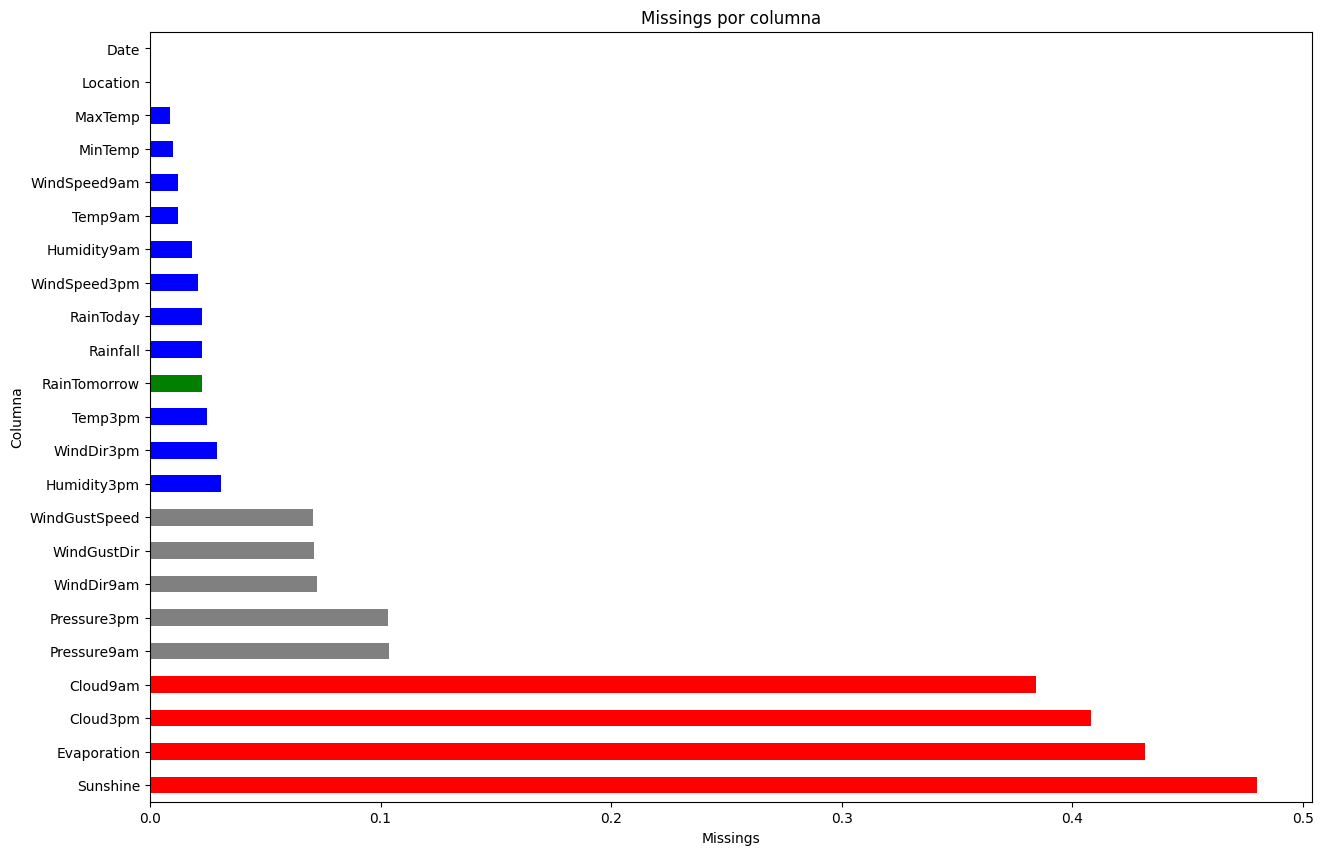

In [10]:
# Grafiquemos..

target = 'RainTomorrow'

# Defino primero una barra de color
colors = ['green' if col == target 
            else 'red' if df_null[col] > 0.30 
            else 'blue' if df_null[col] < 0.05 
            else 'gray' for col in df_null.index]

plt.figure(figsize=(15, 10))
df_null.plot(kind='barh', color=colors)
plt.xlabel('Missings')
plt.ylabel('Columna')
plt.title('Missings por columna')

plt.show()

In [11]:
# Veamos la variable *target*:
df_null[target]

0.02245978275814657

**OBSERVACIONES:**

- Salvo la fecha de la toma de datos `Date` como la localización `Location`, el resto de los *features* presenta *missings* en mayor o menor medida.

- Los atributos `Sunshine`, `Evaporation`, `Cloud3pm` y `Cloud9am` presentan entre un 30% y 50% de datos faltantes.

- El restos de los atributos tienen menos del 10% de datos faltantes.

- La variable *target* `RainTomorrow` presenta un 2.2% de datos faltantes.

- Se observan 2 tipos de variables: numéricas (data type: float64) y categóricas (data type: object).

- La columna `Date` necesita ser convertida a formato de pandas tipo "datetime".

In [12]:
# Convertimos el atributo `Date` a formato de fecha de pandas
# rain_df['Date'] = pd.to_datetime(rain_df['Date'])

In [13]:
# Veamos algo de información estadística
rain_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


**OBSERVACIONES:**

- Se observan varias columnas con *outliers*, por ejemplo, `Rainfall` presenta un valor máximo de 371 cuando el 75% de los datos son menores a 0.80.

#### 3.4 Análisis del target

In [14]:
rain_df['RainTomorrow'].nunique()

2

In [15]:
rain_df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [16]:
rain_df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [17]:
rain_df['RainTomorrow'].value_counts()/ninstances

RainTomorrow
No     0.758394
Yes    0.219146
Name: count, dtype: float64

**OBSERVACIONES:**
- La variable objetivo es binaria y toma valores **Yes** o **No**.

- Se tiene un 75.8% de casos en donde no llueve (No) y un 21.9% donde (Yes). El porcentaje restante correponde al 2.2% de datos faltantes.

A las instancias del *target* donde se tiene *missings*, se las saca del dataset directamente, pues de otro modo, si aplicasemos algún método de imputación, estarías sesgando nuestros resultados.

In [18]:
rain_df.dropna(subset=['RainTomorrow'], inplace=True)

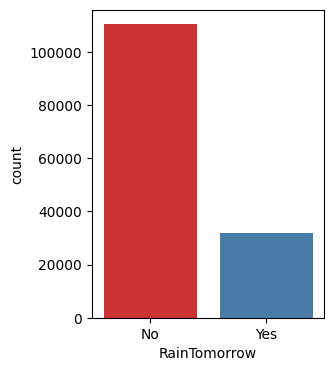

In [19]:
f, ax = plt.subplots(figsize=(3, 4))
ax = sns.countplot(x="RainTomorrow", data=rain_df, palette="Set1", hue="RainTomorrow")
plt.show()

In [20]:
# Cantidad de lugares diferentes donde se tomaron los datos
nloc = rain_df['Location'].nunique()
nloc

location_df = pd.DataFrame(rain_df['Location'].unique(),columns=['Location']).sort_values(by='Location')

def get_geocoord(place):
    'Función para obtener la latitud y longitud de un lugar "place" en Australia'
    
    country = 'Australia'
    # Divide las palabras (en caso de que sea necesario)
    place = re.sub(r'([a-z])([A-Z])', r'\1 \2', place)
    
    # Crear un objeto geolocalizador
    geolocator = Nominatim(user_agent="myGeocoder")
    
    location = f"{place}, {country}"
    location_info = geolocator.geocode(location)
    
    if location_info:
        return (location_info.latitude, location_info.longitude)
    else:
        return (None, None)

place_coords = {}
for location in location_df['Location']:
    place_coords[location] = get_geocoord(location)


### 4. TRAIN & TEST SET

In [21]:
X_full = rain_df.drop(columns=['RainTomorrow'])                 # Drop the target column from features
y_full = np.where(rain_df['RainTomorrow'] == "Yes", 1, 0)       # Target variable

# Split the dataset
rnd_seed = 42   # For reproducibility         
ftest = 0.20    # Fracción de datos para "train"

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_full, y_full, 
                                                    test_size=ftest,        
                                                    stratify=y_full,       # Keep class proportions the same
                                                    random_state=rnd_seed         
                                                    )

print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (113754, 22)
Valores de y_train: 113754
Dimension de X_test: (28439, 22)
Valores de y_test: 28439


### 5. DATA TRANSFORMATION

In [22]:
# Define PIPELINE for data treatment flow
preproc_pipeline = Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),                                                                         # Split date in day/month/year columns
    ("imputer", HierarchicalImputer()),                                                                                 # Missing imputation                                                                  
    ("coordinates", CoordinateTransformer2(place_coords)),                                                               # Convert "Location" into Latitude and Longitude
    ("wind_direction", WindDirectionTransformer()),                                                                     # Convert cardinal direction into degree
    ("wind_direction_deg", ExtendedWindDirectionTransformer()),                                                         # Convert degree into cos and sin
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm",])),                  # Drop categorical columns
    ("drop_directions_deg", DropColumnsTransformer(columns=["WindGustDirDeg", "WindDir9amDeg", "WindDir3pmDeg",])),     # Drop auxiliary columns
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),                                        # Drop categorical columns
    ("rain_today", RainTodayTransformer()),                                                                             # Convert binary variable
    ("null_count", CountNullsTransformer()),
    ("minmax", MinMaxScaler()),                                                                                         # Scale features
])

In [23]:
X_train_transformed = preproc_pipeline.fit_transform(X_train)

In [24]:
# Generate subsampling for hyperparameter tunning
sample_frac = 0.10

(X_train_transformed_sampled, y_train_sampled) = sample_array(X_train_transformed, y_train.reshape(-1, 1), sample_frac)

In [25]:
# Transform test data based on training fit
X_test_transformed = preproc_pipeline.transform(X_test)

### 6. LOGISTIC REGRESSION

#### 6.1 Baseline Logistic Regression Model

In [26]:
from sklearn.linear_model import LogisticRegression

# Entrenamos el modelo por máxima verosimilitud
log_ria = LogisticRegression(random_state = 0, 
                            class_weight='balanced',    # Balanceamos por la diferencia de proporciones de clases
                            n_jobs=12)       
log_ria.fit(X_train_transformed, y_train)

LogisticRegression(class_weight='balanced', n_jobs=12, random_state=0)

#### 6.2 Feature selection using L1 Logistic Regresion

In [29]:
from sklearn.model_selection import cross_val_score

log_model = LogisticRegression(random_state = 0, 
                                class_weight='balanced',
                                n_jobs=12) 

log_model.fit(X_train_transformed_sampled, y_train_sampled)

nfeatures = X_train_transformed_sampled.shape[1]                # Cantidad de atributos

# Generamos varios valores de alpha para la búsqueda pedida
nalpha = 100
alphamin = 0.0
alphamax = 100
alpha_values = np.linspace(alphamin, alphamax, nalpha)

nfolds = 3      # Cantidad de validaciones cruzadas

# Inicializo arraglos para guardar coeficientes de Lasso
coeffs_lasso = np.zeros([nalpha, nfeatures])

# Inicializo arraglos para guardar MSE promedio de cross-validation, para cada alpha
acc_lasso = np.zeros([nalpha])

# Guardamos los coeficientes de la regresión logistica (alpha = 0)
coeffs_lasso[0, :] = log_model.coef_.copy()

# Calculamos los coeficientes para diferentes valores de alpha
for index, alpha in enumerate(alpha_values):

    if index == 0:  
        acc_lr_cv = cross_val_score(log_model, 
                                    X_train_transformed_sampled, y=y_train_sampled, 
                                    scoring='accuracy', 
                                    cv=nfolds, 
                                    n_jobs=12)       # Obtenemos el set de accurary por Cross-validation para linear regression
        acc_lr = acc_lr_cv.mean()       # accuracy mean
        acc_lasso[0] = acc_lr            
        
        continue

    # Creamos los modelos
    logL1_model = LogisticRegression(random_state = 0, 
                                    class_weight='balanced',
                                    n_jobs=12,
                                    penalty='l1',
                                    C=1/alpha, 
                                    solver='liblinear')

    # Los entrenamos
    logL1_model.fit(X_train_transformed_sampled, y_train_sampled)

    # Obtenemos el set de ACC por cross-validation
    acc_lasso_cv  = cross_val_score(logL1_model, 
                                    X_train_transformed_sampled, y=y_train_sampled, 
                                    scoring='accuracy', 
                                    cv=nfolds, 
                                    n_jobs=12)

    # Obtenemos el ACC medio
    acc_lasso[index] = acc_lasso_cv.mean()
    
    # Guardamos los coeficientes de las regresiones
    coeffs_lasso[index, :] = logL1_model.coef_.copy()

# Convertimos los resultados en un DataFrame para visualizarlos
Alpha_vs_MSE_df = pd.DataFrame({
    'Alpha': alpha_values,
    'ACC_Lasso': acc_lasso, 
    })

c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\badesia\AppData\Local\Programs\Pyth

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


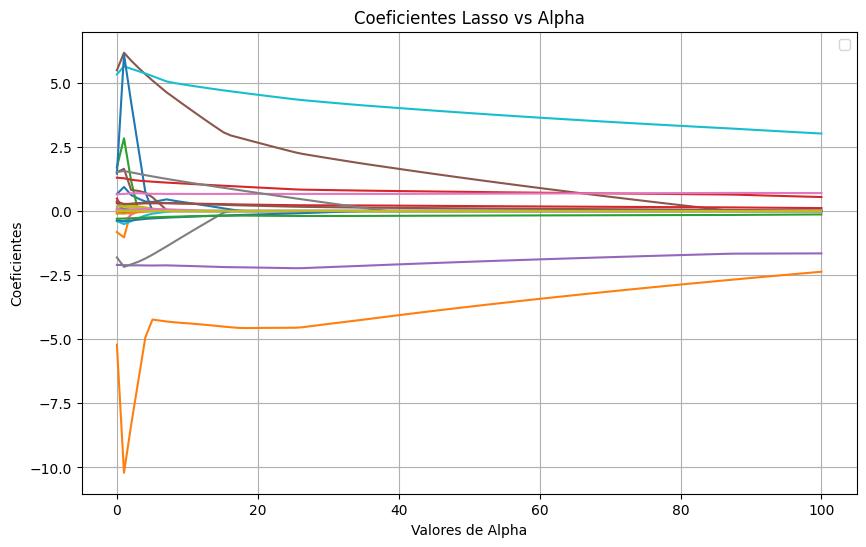

In [30]:
# Crear la figura y los ejes para la gráfica
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Graficar los coeficientes
for i in range(coeffs_lasso.shape[1]):
    ax.plot(alpha_values, coeffs_lasso[:, i])

# Configuraciones adicionales de la gráfica
ax.set_title('Coeficientes Lasso vs Alpha')
ax.set_xlabel('Valores de Alpha')
ax.set_ylabel('Coeficientes')
ax.legend()
# ax.set_xscale('log')  # Usar escala logarítmica si alpha tiene un rango amplio
ax.grid(True)

# Mostrar la gráfica
plt.show()

### 7. SUPPORT VECTOR MACHINE MODEL

#### 7.1 Hyperparameters tunning

In [32]:
from sklearn.svm import SVC

svm_ria = SVC()

grid = GridSearchCV(svm_ria,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=False,
                    cv=5,
                    scoring='f1',
                    verbose = 1,
                    n_jobs=12)

grid.fit(X_train_transformed_sampled, y_train_sampled)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=12,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'gamma': [0.1, 0.5, 1, 2, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']}],
             refit=False, scoring='f1', verbose=1)

In [33]:
# Guardamos los mejores parámetros
best_params = grid.best_params_
best_params 


{'C': 5, 'degree': 4, 'kernel': 'poly'}

#### 7.2 Best SVM model

In [ ]:
# Definimos el mejor modelo
svm_ria_best = SVC(**best_params)

# Entrenamos para todo el set de entrenamiento
svm_ria_best.fit(X_train_transformed, y_train)

### 8. MÉTRICAS DE PERFORMANCE

In [ ]:
# Predecimos sobre el set de testeo para cada modelo
y_pred_log = log_ria.predict(X_test_transformed)        # Base Logistic model
y_pred_svm = svm_ria_best.predict(X_test_transformed)   # Best SVM model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Veamos la matriz de confusión para cada modelo
cm_log = confusion_matrix(y_test, y_pred_log, labels=log_ria.classes_)          # Base Logistic model
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_ria_best.classes_)     # Best SVM model

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_ria.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Logistic Regression model");

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_ria_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Best SVM Classification model");

In [ ]:
# Veamos algunas métricas
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# ----------------------------------------------------------------
# Logistic Regression
# ----------------------------------------------------------------

print("Logistic Regression model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_log[1, :])
N = np.sum(cm_log[0, :])
TP = cm_log[1, 1]
TN = cm_log[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")

# ----------------------------------------------------------------
# Best SVM Model
# ----------------------------------------------------------------

print("Best SVM model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")

P = np.sum(cm_svm[1, :])
N = np.sum(cm_svm[0, :])
TP = cm_svm[1, 1]
TN = cm_svm[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

# Calculamos las curvas ROC

# ----------------------------------------------------------------
# Logistic Regression
# ----------------------------------------------------------------

prob_log = log_ria.predict_proba(X_test_transformed)[:, -1]             # Obtener las probabilidades
fpr_log, tpr_log, _ = roc_curve(y_test, prob_log)                       # Calcular la curva ROC

# ----------------------------------------------------------------
# Best SVM Model
# ----------------------------------------------------------------

decision_scores_svm = svm_ria_best.decision_function(X_test_transformed)    # Obtener las puntuaciones de decisión
fpr_svm, tpr_svm, _ = roc_curve(y_test, decision_scores_svm)                    # Calcular la curva ROC


# Gráficamos las curvas ROC

plt.plot(fpr_log, tpr_log, label="Logistic Regression model")
plt.plot(fpr_svm, tpr_svm, label="Best SVM model")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

In [ ]:
from sklearn.metrics import auc, 

# Calcular el área bajo la curva ROC (AUC)

auc_log = auc(fpr_log, tpr_log)
auc_svm = auc(fpr_svm, tpr_svm)

print("AUC")
print("\n")
print(f"Logistic Regression Model AUC: {auc_log}")
print(f"Best SVM Model AUC: {auc_svm}")

**OBSERVACIONES**

- En términos de área bajo la curva (AUC), el modelo de **Regresión Logística** es el mejor. 

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
svc_disp = RocCurveDisplay.from_estimator(svm_ria_best, X_test_transformed, y_test, ax=ax)

plt.show();